# Introduction to Feature Selection

-----

After data have been cleaned and prepared for analysis, an important next step for many machine learning applications is the identification of the features in the data that are the most important. This process is formally known as [_Feature Selection_][wfs]. In some cases a domain expert can indicate which features have the most predictive power and which features can be ignored. When this is not possible (and in some cases even when it is possible), we can employ algorithmic feature selection to automatically quantify the importance of features so that a threshold can be used to identify the best features for a particular application.

Broadly speaking there are three ways that feature selection can be algorithmically performed. The features can be selected by filtering, by wrapping the selection by another technique, and by embedding the selection in another technique.

Filtering typically involves the application of a statistical measure to  score the different features. This score allows the features to be ranked, and this ranking is used to determine which features to keep and which can be removed from the data. Generally each feature is considered on its own (i.e., a univariate test). 

Wrapping treats the feature selection process as a machine learning task. Different combinations of features are produced and a predictive algorithm is applied to these combinations to evaluate their importance and a score is produced. The different scores allow the different features to be ranked, which can be used to select the best features.

Embedding performs feature selection directly in the model construction. For example, decision tree based technique compute feature importance and regularization methods penalize complex models. This extra information can be used to rank features for use with these models.

The scikit learn provides a number of [feature selection algorithms][skfs] that implement these techniques. These methods often seek to find features that are independent or have high variation, as these will generally provide the most predictive power. The rest of this notebook explores them in more detail.

-----

[wfs]: https://en.wikipedia.org/wiki/Feature_selection
[skfs]: http://scikit-learn.org/stable/modules/feature_selection.html

## Table of Contents

[Data](#Data)

[Statistical Tests](#Statistical-Tests)

[Univariate Techniques](#Univariate-Techniques)

[Recursive Feature Extraction](#Recursive-Feature-Extraction)

[Select From Model](#Select-From-Model)

[Pipeline Feature Selection](#Pipeline-Feature-Selection)

 
-----

Before proceeding with the rest of this notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set global fiugure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default seaborn plotting style
sns.set_style('white')

# Some cells take a while to run, so we will time them
from time import time

-----
[[Back to TOC]](#Table-of-Contents)

## Data

To perform feature selection, we need representative data. In this section we introduce the two data sets that we use to perform feature selection within this notebook.


### Iris Data

The first data set we use to perform feature selection is the [Iris data][id] included in the scikit learn library. These data contain four features: Petal Length, Petal Width, Sepal Length, and Sepal Width, for three different Iris varieties. In total, there are fifty examples of each type of Iris, for 150 total instances in the data set. To increase the challenge, we will occasionally add random _noise_ features to these data in order to test if a feature selection technique can distinguish between signal and noise.

-----

[id]: http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [2]:
import sklearn.datasets as ds

# Load Iris Data
iris = ds.load_iris()

# Extract features & labels
features = iris.data
labels = iris.target

# Output examples of each class
print(f'Feature {features[0]}: Label {labels[0]}')
print(f'Feature {features[50]}: Label {labels[50]}')
print(f'Feature {features[100]}: Label {labels[100]}')

Feature [ 5.1  3.5  1.4  0.2]: Label 0
Feature [ 7.   3.2  4.7  1.4]: Label 1
Feature [ 6.3  3.3  6.   2.5]: Label 2


-----

### Handwritten Digit Data

The second data set we use throughout this notebook is the [handwritten digit data][hdd], which is included in the scikit learn library. These data are digitized images of handwritten digits, zero through nine. The images are eight pixels by eight pixels, for a total of sixty-four pixels, or features. The following Code cell loads these data into the notebook and displays examples of each digit. Notice how the information (or non-zero values) is primarily located in the central columns of each image. These images will provide insight into the performance of the different feature selection techniques demonstrated within this notebook.

-----
[hdd]: http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html

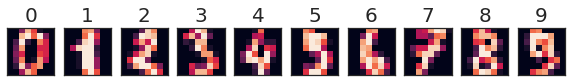

In [3]:
# Load the digits data
digits = ds.load_digits()
    
# Now lets get the data and labels
x = digits.data
y = digits.target
images = digits.images

# Create Figure and axes (we plot ten images side-by-side)
fig, axs = plt.subplots(figsize=(10,8), nrows=1, ncols=10)

for idx in np.arange(10):
        
    # We want square images
    axs[idx].set_aspect('equal')
        
    # Now show the images, by default pixels are shown as white on black.
    # To show black on white, reverse colormap: cmap=plt.cm.gray_r
    # To smooth pixelated images: interpolation='nearest'
    axs[idx].imshow(images[idx], interpolation='nearest')
        
    # No tick marks for small plots
    axs[idx].set_xticks([]) ; axs[idx].set_yticks([])
    
    # Label number        
    axs[idx].set_title(y[idx])

-----
[[Back to TOC]](#Table-of-Contents)

## Statistical Tests

One of the simplest techniques for algorithmically selecting features is to measure the variance, or spread, in each feature. Some machine learning algorithms, such as the decision tree, explicitly measure the variance of features and split those features with the greatest variance. The reason for this approach is that features with the greatest variance contain significant information, whereas features with the least variance are tightly bunched and contain little discriminative power. As an extreme example, a feature that has zero variance provides no descriptive power (since all features have the same value), and can easily be removed from analysis without impacting the predictive performance of an algorithm.

Formally, this technique is known as [variance thresholding][vt], which is implemented in the scikit learn library by the [`VarianceThreshold`][skvt] selector. The following two Code cells demonstrate this technique on the Iris data. First, the technique is applied directly to the Iris data, which provides a ranking of feature importance (via the variance measures). 

However, since the original features are unnormalized, the variance comparison is inaccurate, some features have a naturally larger spread due to the sizes of the widths and lengths of the petals and sepals. Thus, the second Code cell normalizes these features to the same zero to one range, and then performance variance thresholding. Notice how the results change such that the petal width becomes more important than the petal length. This example emphasizes the importance of ensuring that the statistical tests are performed in a uniform manner in order to avoid biasing the results. 


-----

[vt]: http://scikit-learn.org/stable/modules/feature_selection.html#removing-features-with-low-variance
[skvt]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html

In [4]:
# Perform variance thresholding on raw features
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold()

# Compute and display variances
vt.fit_transform(features)
for var, name in zip(vt.variances_, iris.feature_names):
    print(f'{name:>10} variance = {var:5.3f}')

sepal length (cm) variance = 0.681
sepal width (cm) variance = 0.187
petal length (cm) variance = 3.092
petal width (cm) variance = 0.579


In [6]:
# Scale features and then perform variance thresholding
from sklearn.preprocessing import MinMaxScaler
features_ss = MinMaxScaler().fit_transform(features)

# Compute and display variances
vt.fit_transform(features_ss)
for var, name in zip(vt.variances_, iris.feature_names):
    print(f'{name:>10} variance = {var:5.3f}')

sepal length (cm) variance = 0.053
sepal width (cm) variance = 0.032
petal length (cm) variance = 0.089
petal width (cm) variance = 0.100


----

As an additional example, we can apply variance thresholding to the handwritten digit data set. In this case, our goal is to reduce the number of pixels (or features) required to perform a subsequent classification. The following Code cell demonstrates this technique on these data by first scaling the data to the range zero to one, and then performing variance thresholding. Since we do not specify an explicit threshold (we are reusing the previously created `VarianceThreshold` selector), we end up with a sixty-four element array with the variance scores. 

Finally, this result is transformed into an eight by eight image, which displays that the center pixels in the images have the greatest variance. Examining the original images indicates that this intuitively makes sense. The center pixels are most frequently used to represent the digits. This same approach will be used to visualize the results of other feature selection techniques.

The second Code cell provides an explicit threshold value, thus only those pixels (or features) are marked. These pixels are identified by calling the `get_support` method, the name _support_ is used to indicate the features that have the most information, and thus support later making predictions. Furthermore, The selected pixels form a _mask_ that can be used to quickly select those pixels in an image that should be used for classification.

----

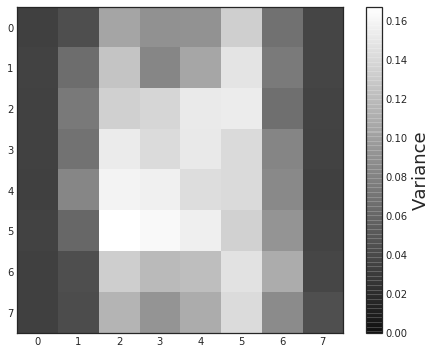

In [7]:
# Create Figure and axes (we plot ten images side-by-side)
fig, axs = plt.subplots(figsize=(8, 6))

# Transform data to [0, 1]
xx = MinMaxScaler().fit_transform(x)

# Fit data to compute variances
vt.fit(xx)

# Show variances as image with colorbar
img = axs.imshow(vt.variances_.reshape((8,8)), cmap='gray', alpha=0.75)
fig.colorbar(img, ax=axs, label='Variance') ;

38 features selected at threshold = 0.06


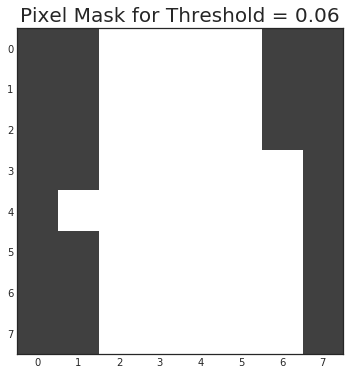

In [8]:
# Define threshold
thresh = 0.06

# Create filter
vt = VarianceThreshold(thresh)

# Fit filter
vt.fit(xx)

# Compute and display mask info
mask = vt.get_support()
print(f'{np.sum(mask)} features selected at threshold = {thresh}')

# Plot mask as image
fig, axs = plt.subplots(figsize=(8, 6))

axs.set_title(f'Pixel Mask for Threshold = {thresh}')
axs.imshow(mask.reshape(8, 8), cmap='gray', alpha=0.75) ;

-----

While the previous visualizations are useful for image data, other types of data are best visualized in a linear manner. To demonstrate the concept of masking in a linear sense, we can perform variance thresholding, as a unction of different thresholds, and display the support as a linear mask. The following Code cell displays the masks for the pixel data linearly for six different variance thresholds. As the threshold increases, fewer pixels are selected. Moving up the masks indicates how different features are selected as the variance threshold is decreased.

-----

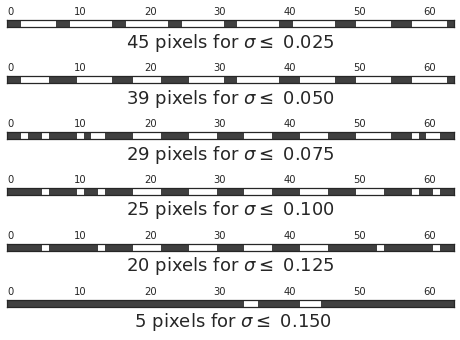

In [9]:
# Plot mask as image
fig, axs = plt.subplots(figsize=(8, 6), nrows=6, ncols=1)

# Select features at difference variance thresholds
for idx, thresh in enumerate(np.linspace(0.025, 0.15, 6)):
    vt = VarianceThreshold(thresh)

    # Fit filter
    vt.fit(xx)
    
    # Compute mask info
    mask = vt.get_support()
    
    # Show mask and label plot    
    axs[idx].matshow(mask.reshape(1, 64), cmap='gray', alpha=0.75)
    axs[idx].set_yticks(())
    axs[idx].set_xlabel(f'{np.sum(mask):2d} pixels for $\sigma \leq$ {thresh:5.3f}')

-----
[[Back to TOC]](#Table-of-Contents)

## Univariate Techniques

Another technique for identifying the features that encode the majority of the signal in a data set is to employ a function that computes a statistical measure of the amount of information contained in a given feature. For example, the function might measure the correlation between two features, since correlated features provide redundant information. 

The two main techniques for performing this type of feature selection are [`SelectKBest`][skb] and [`SelectPercentile`][sp]. The former selects the **k** best features, while the latter selects the best percentage of features. Each of these techniques accepts a `score_func` that implements the statistical measure. Provided measures include the following:
- `f_classif`: computes the ANOVA F-value between the features and labels, used for classification.
- `mutual_info_classif`: computes the mutual information of discrete label, used for classification.
- `chi2`: computes chi-squared statistic of non-negative features, used for classification.
- `f_regression`: computes the ANOVA F-value between the features and labels, used for regression.
- `mutual_info_regression`: computes the mutual information for continuous label, used for regression.

Several other specific techniques are also provided by the scikit learn library, but they are beyond the scope of this notebook. The [online documentation][skut] provides more details on all of these methods.

To demonstrate these techniques, we will start with the original Iris data set. We use the `SelectKBest` technique to compute the scores for all features, and we use the default scoring function which is [`f_classif`][fc]. This statistic measures the degree of linear dependence between two features. The more dependent two features are the less information the second feature provides to the classification method. The results indicate that the petal features are most important, which agrees with the feature importance results we saw in earlier notebooks.

-----
[skut]: http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection
[skb]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
[sp]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html
[fc]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html

In [14]:
from sklearn.feature_selection import SelectKBest

skb = SelectKBest(k='all')

fs = skb.fit(features, labels)
for var, name in zip(fs.scores_, iris.feature_names):
    print(f'{name:>18} score = {var:5.3f}')


 sepal length (cm) score = 119.265
  sepal width (cm) score = 47.364
 petal length (cm) score = 1179.034
  petal width (cm) score = 959.324


-----

To test these techniques more thoroughly, we can add random noise features into the analysis. To do this, the following Code cell generates ten new features (called _NoiseXX_ where the XX is replaced by the ordinal number of the new feature) that contain values that are uniformly sampled from the range zero to one. We combine these new noise features with our Iris data, which have been properly normalized to the same range, by using the NumPy `hstack` method, and we also create a new list of feature names that aligns with our new set of features.

Next, we one again perform feature selection by using the `SelectKBest` technique. Now, however, we display the features, sorted by their relative importance. In this case, the real features are identified with higher importance, although the fluctuations in the noise features indicates that several of them are approaching the importance of the real features.

-----

In [15]:
# Number of noise features to add
num_nf = 10

# Set random state
rng = np.random.RandomState(23)

# Create noise features
noise = rng.uniform(0., 1.0, size=(len(iris.data), num_nf))

# Features plus noise
features_pn = np.hstack((features_ss, noise))

# Feature names
f_names = iris.feature_names.copy()
for i in range(noise.shape[1]):
    f_names.append(f'Noise {i:0>2}')
    
# Fit features plus noise
fs = skb.fit(features_pn, labels)

# Display scores for features and noise
for var, name in sorted(zip(fs.scores_, f_names), 
                        key=lambda x: x[0], reverse=True):
    print(f'{name:>18} score = {var:5.3f}')

 petal length (cm) score = 1179.034
  petal width (cm) score = 959.324
 sepal length (cm) score = 119.265
  sepal width (cm) score = 47.364
          Noise 03 score = 7.669
          Noise 09 score = 3.705
          Noise 00 score = 1.888
          Noise 04 score = 1.447
          Noise 08 score = 0.944
          Noise 02 score = 0.554
          Noise 05 score = 0.417
          Noise 06 score = 0.209
          Noise 01 score = 0.105
          Noise 07 score = 0.020


-----

To provide additional insight into these techniques, we now switch to the handwritten digit data set. These data contain sixty-four features (the pixels in the original images). To display the importances, we generate an image from the output of the feature selection technique. In the following example we use the `SelectKBest` with the chi-squared statistical measure ([`chi2`][c2]). This produces a score array that we can reshape to match the dimensions of the input images. This statistical measure can be used to identify features that are (approximately) independent of class, and thus have little predictive power. 

The generated image indicates that the pixels near the center of the image have the highest predictive power, although several pixels near the edge have very high values. These pixels are likely important to determine one or two classes (such as a seven), and thus might not be identified with other approaches that focus on the global predictive importance.

-----
[c2]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html

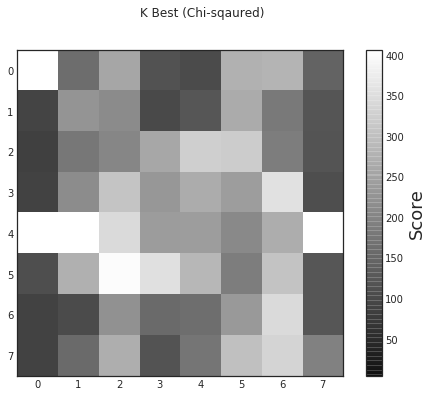

In [16]:
from sklearn.feature_selection import chi2

skb = SelectKBest(chi2, k='all')
fs = skb.fit(xx, y)

# Create Figure and axes (we plot ten images side-by-side)
fig, axs = plt.subplots(figsize=(8, 6))

plt.suptitle(f'K Best (Chi-sqaured)')

# Show variances as image with colorbar
img = axs.imshow(fs.scores_.reshape((8,8)), cmap='gray', alpha=0.75)
fig.colorbar(img, ax=axs, label='Score') ;

----

We can change the statistical measure to intentionally select different features, for example, the [`mutual_info_classif`][mi] statistical measure quantifies the dependency between two features. This measure uses a non-parametric (or model free) entropy measurement from the nearest neighbor distances. When two features are independent, this statistic goes to zero, and as the dependency increases the statistics also increases.

The following Code cell demonstrates this statistic with the `SelectKBest` technique. We indicate all features should be selected, which allows for the feature scores to be converted into an image with which to compare the relative feature importance. Notice that this statistics emphasizes the central pixels, which is where the majority of the signal resides for the digits. Unlike the chi-squared statistic, which indicated select outer pixels provided information useful in identifying specific classes, the mutual information identifies those pixels that provide the most information for all of the classifications.

-----

[mi]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html

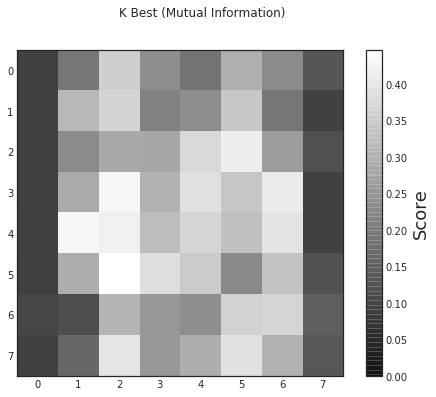

In [13]:
from sklearn.feature_selection import mutual_info_classif

skb = SelectKBest(mutual_info_classif, k='all')
fs = skb.fit(xx, y)

# Create Figure and axes (we plot ten images side-by-side)
fig, axs = plt.subplots(figsize=(8, 6))

plt.suptitle(f'K Best (Mutual Information)')

# Show variances as image with colorbar
img = axs.imshow(fs.scores_.reshape((8,8)), cmap='gray', alpha=0.75)
fig.colorbar(img, ax=axs, label='Score') ;

-----

One of the other popular techniques is to select a percentage of best features, which can be done by using the [`SelectPercentile`][sp] technique. To determine the best percentile of all of the features, we need to specify a scoring function, and the percentile. The following Code cell demonstrates this technique on the digit data using the `mutual_info_classif` statistical measure.

-----

[sp]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html

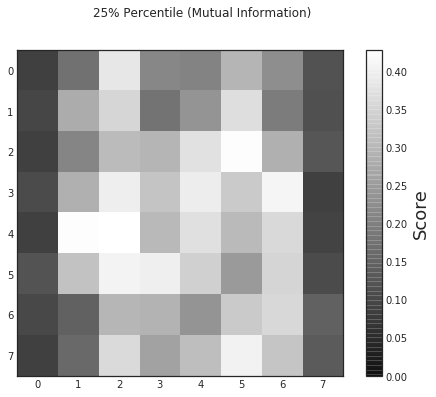

In [17]:
from sklearn.feature_selection import SelectPercentile

sp = SelectPercentile(mutual_info_classif, percentile=25)
fs = sp.fit(xx, y)

# Create Figure and axes (we plot ten images side-by-side)
fig, axs = plt.subplots(figsize=(8, 6))

plt.suptitle(f'25% Percentile (Mutual Information)')

# Show variances as image with colorbar
img = axs.imshow(fs.scores_.reshape((8,8)), cmap='gray', alpha=0.75)
fig.colorbar(img, ax=axs, label='Score') ;

-----

While these features are perhaps most intuitively understood when displayed as an image, this is not always the case. As a result, the following Code cell selects the feature percentiles, using the same statistical measure, for the digit data. The features are now displayed linearly as a mask by using the matplotlib `matshow` method. The selected features are marked as white, and the unselected features are marked as black. This _mask_ is generated by calling the `get_support` method (the selected features are known as the _support_) on the feature selector.

-----

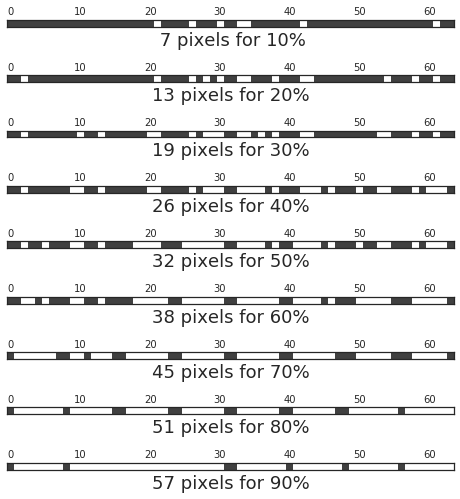

In [18]:
# Plot mask as image
fig, axs = plt.subplots(figsize=(8, 9), nrows=9, ncols=1)

# Compute and display features for different precentiles
for idx, prcnt in enumerate(np.linspace(10, 90, 9)):
    sp = SelectPercentile(mutual_info_classif, percentile=prcnt)

    # Fit filter
    sp.fit(xx, y)
    
    # Compute mask info
    mask = sp.get_support()
    
    # Show mask and label plot    
    axs[idx].matshow(mask.reshape(1, 64), cmap='gray', alpha=0.75)
    axs[idx].set_yticks(())
    axs[idx].set_xlabel(f'{np.sum(mask):2d} pixels for {int(prcnt):2d}%')

-----
[[Back to TOC]](#Table-of-Contents)

## Recursive Feature Extraction

[Recursive Feature Elimination (RFE)][rfe] works by recursively removing attributes and building a model from the remaining attributes. The model accuracy is used to identify the attributes (and combination of attributes) that most contribute to predicting the target (or held-out) attribute. The RFE implementation provided by the scikit learn library is in the `feature_selection` module.

In the next few cells, we employ both RFE to determine the most important features for both the Iris and Handwritten Digit data. The first Code cell below uses a linear support vector classifier to perform RFE. In this case, we analyze the Iris data set plus ten _noise_ features. The result of this operation identifies the most important feature (since we specified that the top feature should be identified),  but also ranks the remaining features. Notice how three of the _real_ features are the top three ranked features, but next are several _noise_ features, indicating the the remaining _real_ feature encodes less information than a random feature.

-----

[rfe]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html



In [19]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE

# Create classifier
svc = LinearSVC(random_state=23)

# Perform RFE, select top feature (but rank all)
rfe = RFE(svc, 1)

# Fit features plus noise
fs = rfe.fit(features_pn, labels)
    
# Display scores for features and noise
for var, name in sorted(zip(fs.ranking_, f_names), 
                        key=lambda x: x[0]):
    print(f'{name:>18} rank = {var:5.3f}')

  petal width (cm) rank = 1.000
 petal length (cm) rank = 2.000
  sepal width (cm) rank = 3.000
          Noise 03 rank = 4.000
          Noise 09 rank = 5.000
          Noise 00 rank = 6.000
 sepal length (cm) rank = 7.000
          Noise 07 rank = 8.000
          Noise 05 rank = 9.000
          Noise 06 rank = 10.000
          Noise 02 rank = 11.000
          Noise 08 rank = 12.000
          Noise 04 rank = 13.000
          Noise 01 rank = 14.000


-----

We now transition to the handwritten digit data set, which has sixty-four features. In this following demonstration, we display the feature rankings by displaying the pixels encoded by their rank (which is also displayed in each pixel).  The pixel rankings look reasonable, most of the signal in the original images are located near the center, for example review the original ten digit images shown at the start of this notebook.

-----

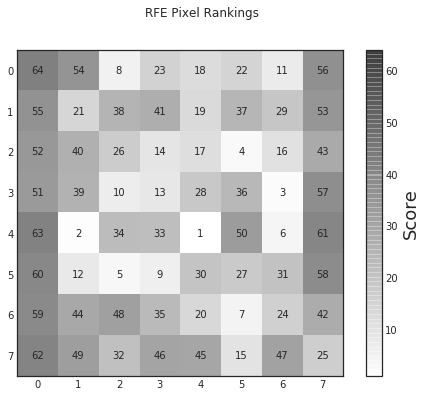

In [20]:
# Create RFE model with only one feature
rfe = RFE(svc, 1)
rfe = rfe.fit(xx, y)

# Create Figure and axes
fig, axs = plt.subplots(figsize=(8, 6))
plt.suptitle(f'RFE Pixel Rankings')

# Show variances as image with colorbar
img = axs.imshow(rfe.ranking_.reshape((8,8)), cmap='gray_r', alpha=0.5)
fig.colorbar(img, ax=axs, label='Score') ;

# Label pixels
for (j, i), label in np.ndenumerate(rfe.ranking_.reshape((8,8))):
    axs.text(i, j, label, ha='center', va='center')

-----

While the previous Code cell provided a ranking of all pixels, we might wish to specify a predefined number of features that should be kept. The following Code cell demonstrates this by indicating sixteen attributes should be kept as a parameter to the RFE model. The result is display as an image mask, where the white pixels are those features that should be kept in subsequent analysis. The kept pixels are obtained by calling the `get_support` method, which returns the selected features, which are known as the _support_. Changing this parameter value would include more or fewer pixels.


-----

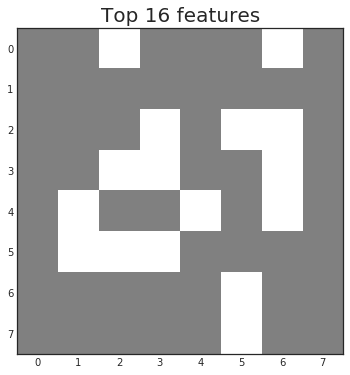

In [21]:
# Number of attributes to keep
num_attributes = 16

# Create RFE model with target number of attributes
rfe = RFE(svc, num_attributes)
rfe = rfe.fit(xx, y)

# Compute and display mask info
mask = rfe.get_support()

# Plot mask as image
fig, axs = plt.subplots(figsize=(8, 6))

axs.set_title(f'Top {np.sum(mask)} features')
axs.imshow(mask.reshape(8, 8), cmap='gray', alpha=0.5) ;

-----

<font color='red' size = '5'> Student Exercise </font>

Now that you have run the previous cells, try making changes to the
Notebook:

1. Change the number of features to retain with RFE when applied to the digit data. How does increasing or decreasing the number of features change the RFE pixel image?

2. Try using a different classifier, such as a random forest or gradient boosted trees.

-----

[[Back to TOC]](#Table-of-Contents)

## Select From Model


Of course some algorithms, such as the decision tree and the ensemble techniques based on a decision tree, provide access to measures of the feature importance. For example, the [Random Forest Classifier (RFC)][rfc], as an ensemble method, builds models by randomly selecting features when building each tree. In this process, RFC computes the overall importance of each feature in building the final model. By extracting the feature importances from the final model, we obtain a ranked ordering of the features used to build the model.

In the following Code cell, we employ RFC to determine the most important features for the Iris data set (along with the added _noise_ features). With this estimator, the four _real_ features are all ranked as the most important, followed by the _noise_ features. However, the sepal features are ranked with low importance, nearly the same as the noise features. This explains why different techniques can produce different feature rankings, small changes to the algorithm or any inherent randomness in the process can generate different results.

-----

[rfc]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

-----

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Build model
rfc = RandomForestClassifier(random_state=23)
rfc.fit(features_pn, labels)

# Display scores for features and noise
print(f'{"Label":18s}: Importance')
print(26*'-')
for val, name in sorted(zip(rfc.feature_importances_, f_names), 
                        key=lambda x: x[0], reverse=True):
    print(f'{name:>18}: {100.0*val:05.2f}%')

Label             : Importance
--------------------------
 petal length (cm): 39.97%
  petal width (cm): 25.39%
 sepal length (cm): 06.62%
  sepal width (cm): 04.31%
          Noise 02: 04.08%
          Noise 04: 03.97%
          Noise 03: 03.44%
          Noise 05: 02.32%
          Noise 00: 02.21%
          Noise 01: 02.12%
          Noise 09: 02.12%
          Noise 07: 01.21%
          Noise 06: 01.19%
          Noise 08: 01.05%


-----

We can extend this concept to use any algorithm to perform model-based feature selection by using the [`SelectFromModel`][sfm] estimator in the `feature_selection` module. This algorithm uses an estimator that provides some measure of feature importance to rank the features and (optionally) to transform the input feature space into a new, smaller feature space based on these rankings. Formally, the estimators that can be used by the `SelectFromModel` estimator must measure feature importance, such as a decision tree, or compute weights for the input features, which is done by many of the linear models (e.g., Linear SVC).  Furthermore, this technique can easily be applied within a Pipeline to restrict the number of features used in subsequent analyses.

This approach is introduced in the following Code cell, where we reuse the pre-trained random forest classifier in the `SelectFromModel` estimator. Since the estimator has already been fit, we can simply call the `transform` method directly and generate the new set of features. In this case, the default values select only the top two features, which encode the majority of the feature importance (as shown in the previous example).

-----
[sfm]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html

In [23]:
from sklearn.feature_selection import SelectFromModel

# Create model, since we are using a prefit classifier 
# (from above), we call transform directly
sfm = SelectFromModel(rfc, prefit=True)
features_new = sfm.transform(features_pn)

# Display scores for features and noise
print('Most important labels')
print(20*'-')
for spt, name in zip(sfm.get_support(), f_names):
    if spt:
        print(f'{name:>18}')

Most important labels
--------------------
 petal length (cm)
  petal width (cm)


-----

We now apply the `SelectFromModel` estimator to the handwritten digit data. By default, `SelectFromModel` uses the mean as the threshold to select features. In the following Code cell, we first apply a mask to the input data, which can be used to restrict the classes analyzed. By default, all digits are kept, but by changing the `minc` or `maxc` variables, specific classes can be excluded form the analysis.

Next, a random forest is trained on these data, and this pre-fit model is used to select the top features. Since we kept the default values, for this input feature space the random forest classifier selects thirty-two features (or half), which are displayed as an image mask. The image mask indicates which pixels encode the majority of the signal, and visually this result makes sense since most of the images have information near the center of the image.

-----

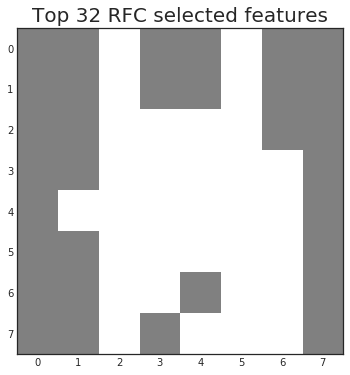

In [24]:
# We can restrict the classes (digit labels)
# By default, we keep themn all 0-9
minc = 0 ; maxc = 10
mask = (y >= minc) & (y < maxc)  # Limit classes
xx_m = xx[mask]
y_m = y[mask]

# Build Random Forest
rfc = RandomForestClassifier(n_estimators=1000, random_state=23)
rfc.fit(xx_m, y_m)

# Select top features
sfm = SelectFromModel(rfc, prefit=True)

# Compute and display mask info
mask = sfm.get_support()

# Plot mask as image
fig, axs = plt.subplots(figsize=(8, 6))

axs.set_title(f'Top {np.sum(mask)} RFC selected features')
axs.imshow(mask.reshape(8, 8), cmap='gray', alpha=0.5) ;

-----

<font color='red' size = '5'> Student Exercise </font>

Now that you have run the previous cells, try making changes to the
notebook:

2. Try changing the number of estimators (i.e., trees), or other hyperparameters for the RFC estimator. How does increasing/decreasing these values change the RFC Pixel image?
3. Try changing the number of features retained in the RFC estimator by altering the threshold in `SelectFromModel`. 

Finally, think about the information contained in the RFE and RFC pixel images, does this provide any insight into the data, and how the classifications performed.

-----

[[Back to TOC]](#Table-of-Contents)

## Pipeline Feature Selection

In practice, feature selection is part of the overall machine learning process. Different sets of features may be selected with different models or different hyperparameters for the same model. Thus, feature selection is often done within a pipeline in order to automate this process. 

The following set of Code cells demonstrate this process. First, the handwritten digit data set is split into a training and testing sample. This process reserves 25% of the data for testing and stratifies the training and testing to maintain rough class proportions. Next, a pipeline is created to perform feature selection, in this case we use the `SelectPercentile` estimator, which will select the top **k**% of features. To score the features we create a random forest classifier. Finally, we create a stratified k-fold cross validation to select the best model hyperparameters, in this case we will seek to identify the best value for **k**, which is the percentile of features to retain.

-----

In [25]:
# Generate train:test splits
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = \
    train_test_split(xx, y, test_size = 0.25, 
                     stratify=y, random_state=23)

In [26]:
from sklearn.pipeline import Pipeline

# Feature selection as part of a pipeline
# Use random forest to classify data
pl = Pipeline([('sp', SelectPercentile()),
               ('rfc', RandomForestClassifier(n_estimators=1000, 
                                              random_state=23))])

In [28]:
# Create stratifid k-fold cross validation
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=23)

-----

With the preliminaries completed, we can turn to the execution of this pipeline. First, we will use the `cross_val_score` method to compute cross validation scores for each hyperparameter value. The hyperparameters that we test are the percentage of total features selected, which extend from 10% to 90%, in steps of 10%. We iterate through these hyperparameter values, and compute the mean and standard deviation of the cross validation scores.

Once this process is completed, we display the overall running time, which is non-trivial since we are performing five-fold cross-validation for nine hyperparameter values. In the second Code cell, we compute the best cross validation score and corresponding best percentile. This computation indicates that 70% of our training data (or a little over half of the total data) provides the best performance.

-----

In [29]:
from sklearn.model_selection import cross_val_score

# Start clock
start = time()

# percentile hyperparameter values
percentiles = np.arange(10, 100, 10)

# Create arrays to hold cross-validation statistics
scr_mean = np.zeros(percentiles.shape)
scr_std = np.zeros(percentiles.shape)

# Loop over parameter values to accumulate statistics
for idx, pct in enumerate(percentiles):
    pl.set_params(sp__percentile=pct)
    score = cross_val_score(pl, x_train, y_train, cv=skf)
    scr_mean[idx] = np.mean(score)
    scr_std[idx] = np.std(score)

# Display compute time
print(f'Compute time = {time() - start:4.2f} seconds.')

Compute time = 121.73 seconds.


In [30]:
# Find best score (from means of scores)
idx = np.argmax(scr_mean)

# Display best score (and error) and associated percentile
print(f'Best Score = {scr_mean[idx]:5.3f} +/- {scr_std[idx]:5.3f}')
print(f'Best Percentile = {percentiles[idx]:5.3f}')

Best Score = 0.973 +/- 0.010
Best Percentile = 70.000


-----

Since we computed the mean and standard deviation of the cross-validation scores, we can plot the performance as a function of percentage of the training data used. The following Code cell creates this plot, which shows that by 70% of the training data, the classifier has reached an equilibrium in classification accuracy (which is quite high).

-----

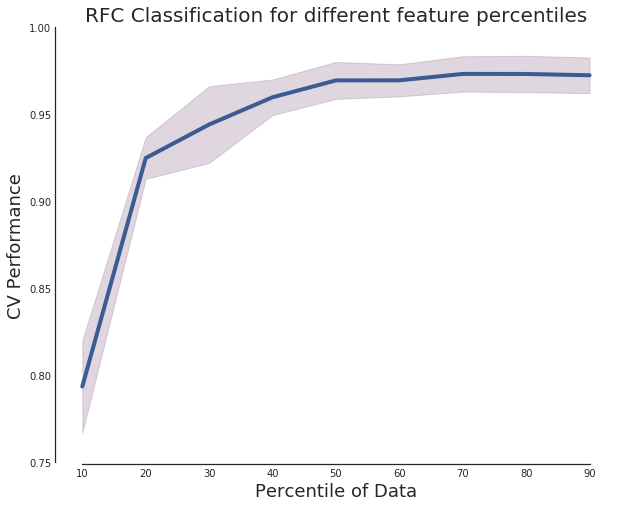

In [31]:
# Define confidence interval
high = scr_mean + scr_std
low = scr_mean - scr_std

# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(percentiles, scr_mean,
        color=sns.xkcd_rgb["denim blue"], linewidth=4)

ax.fill_between(percentiles, high, low,
                color=sns.xkcd_rgb["dusty purple"], alpha=0.25)
ax.set(title='RFC Classification for different feature percentiles', 
       xlabel='Percentile of Data', ylabel='CV Performance')
ax.set_ylim(0.75, 1.0)
sns.despine(offset=2, trim=True)

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

4. Detailed discussion of [feature engineering][1]
1. Series of blog articles on feature selection in Python: [Part I][2a], [Part II][2b], [Part II][2c], and [Part IV][2d]
2. An introduction to [feature selection][3]


-----

[1]: http://adataanalyst.com/machine-learning/comprehensive-guide-feature-engineering/
[2a]: http://blog.datadive.net/selecting-good-features-part-i-univariate-selection/
[2b]: http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/
[2c]: http://blog.datadive.net/selecting-good-features-part-iii-random-forests/
[2d]: http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/

[3]: https://machinelearningmastery.com/an-introduction-to-feature-selection/

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode 